# Motivation

We observed three strong electron precipitation which lasted for 3 hours from ELFIN missions.

We wanted to investigate the cause of the precipitation.

<div float="left">
  <img src="../figures/elx_pef_en_spec2plot_event01.png" width="30%">
  <img src="../figures/elx_pef_en_spec2plot_event02.png" width="30%">
  <img src="../figures/elx_pef_en_spec2plot_event03.png" width="30%">
</div>

In [58]:

# | code-summary: Import all the libraries
# To make quarto render holoview properly, somehow you can not use `output: false` in the cell options
import logging

import altair as alt
import holoviews as hv
import hvplot.pandas  # noqa
import hvplot.xarray  # noqa
import numpy as np
import pandas as pd
import panel as pn
import pdpipe as pdp
import proplot as pplt
import pyspedas
import xarray as xr
from icecream import ic
from plasmapy.formulary import gyrofrequency
from pyspedas import tinterpol
from pytplot import get_data, options, split_vec, store_data, tplot, tplot_options

import pickle
import os

from utilities import *

logger = logging.getLogger()

pplt.rc["svg.fonttype"] = "none"
pplt.rc['formatter.timerotation'] = 0
pplt.rc['lines.linewidth'] = 1 # default: 1.5
journal = 'agu2'
tplot_refwidth = '128mm'
tplot_refheight = '27mm'
ax_format_args = { "margin": 0.1 , "xlocator": ('hour', range(0, 24, 3)) }

In [5]:
# | code-summary: Paramaters of this notebook
PLOT = True
trange = ["2021-04-17T00:00:00", "2021-04-17T12:00:00"]

### Indices subplot

In [22]:
!wget -nc -O supermag_api.py https://supermag.jhuapl.edu/mag/lib/content/api/supermag-api.py
# -nc, --no-clobber                skip downloads that would download to existing files (overwriting them)

--2023-09-09 04:29:31--  https://supermag.jhuapl.edu/mag/lib/content/api/supermag-api.py
Resolving supermag.jhuapl.edu (supermag.jhuapl.edu)... 128.244.181.39
Connecting to supermag.jhuapl.edu (supermag.jhuapl.edu)|128.244.181.39|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 25735 (25K)
Saving to: ‘supermag_api.py’

supermag_api.py     100%[===================>]  25.13K  --.-KB/s    in 0.1s    

2023-09-09 04:29:31 (262 KB/s) - ‘supermag_api.py’ saved [25735/25735]



In [6]:
# code-summary: get indices from SuperMAG
from supermag_api import SuperMAGGetIndices

logon = 'Overhaul2993'
start = trange[0]
extent =  (pd.Timestamp(trange[1]) - pd.Timestamp(trange[0])).total_seconds()
sm_indices = 'SME'

status, idxdata = SuperMAGGetIndices(logon, start, extent, sm_indices)
idxdata['tval']  = pd.to_datetime(idxdata['tval'], unit='s')

# convert idxdata into xarray
sme = xr.DataArray(
    idxdata['SME'].values, coords = {'time': idxdata['tval'].values},
    attrs={'long_name': 'SME', 'units': 'nT'}
)

In [7]:
# code-summary: get indices from OMNI

varnames = ['SYM_H']

omni_vars = pyspedas.omni.data(trange=trange, varnames = varnames)
sym_h = get_data("SYM_H", xarray=True)
sym_h.attrs['long_name'] = 'SYM-H'
sym_h.attrs['units'] = 'nT'

# tplot(['SYM_H'], save_svg='../figures/omni_SYM_H')

09-Sep-23 11:42:01: Downloading remote index: https://spdf.gsfc.nasa.gov/pub/data/omni/omni_cdaweb/hro2_1min/2021/
09-Sep-23 11:42:02: File is current: /Users/zijin/data/omni/hro2_1min/2021/omni_hro2_1min_20210401_v01.cdf
09-Sep-23 11:42:02: Time clip was applied to: SYM_H


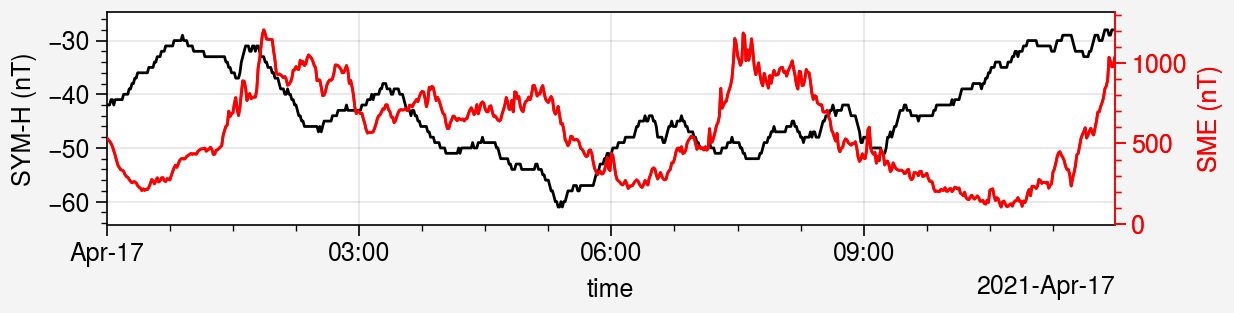

In [57]:
def label_formatter(da: xr.DataArray):
    if 'units' in da.attrs.keys() and da.units != "":
        return f"{da.long_name} ({da.units})"
    else:
        return da.long_name

def plot_indices(save=False):
    fname = 'indices_SYM_H_SME'
    
    fig, ax = pplt.subplots(refwidth=tplot_refwidth, refheight=tplot_refheight)

    ax.plot(sym_h, color='black')
    temp_ax = ax.alty(color='red', label=label_formatter(sme))
    temp_ax.plot(sme, color='red')
    
    ax.format(**ax_format_args)
    temp_ax.format(**ax_format_args)

    if save:
        fig.savefig(f'../figures/{fname}.svg')
        fig.savefig(f'../figures/{fname}.pdf')
        
    return fig

# fig = plot_indices()
fig = plot_indices(save=True)

# Detailed analysis of the April 17 2021 event

## ELFIN observations of EMIC driven precipitations during >3hour interval

Two ELFIN satellites observation of EMIC-driven precipitation (where the precipitation flux surpasses the trapped flux in high-energy channels) over an interval exceeding three hours, from 02:42 to 05:53. The locations are projected in proximity to the L-Shell and MLT, using the Tsyganenko (1989) magnetic field model. Panels (a), (b), and (d) encapsulate data from ELFIN-B, while panel (c) features observations from ELFIN-A.

![](../figures/elfin_j_ratio.png)

## ARASE Part

### ARASE observation of whistler wave

Process data from the ERG satellite: retrieve data, interpolate to the same time as the spectra, and export tplot variables

###  ARASE electron and proton observations 

In [38]:
# | code-summary: Retrieve ARASE data
# | output: false

trange = ["2021-04-17T00", "2021-04-17T12"]

vars = {
    "erg_part_electron": "erg_mepe_l2_omniflux_FEDO",
    "erg_part_proton": "erg_mepi_l2_omniflux_FODO",
    "erg_bvec": "erg_mgf_l2_mag_8sec_gsm",
    "erg_mec_mlt": "erg_orb_l2_pos_mlt",
    "erg_mec_l": "erg_orb_l2_pos_Lm",
}

pyspedas.erg.mepe(trange=trange, time_clip=True, ror=False)
pyspedas.erg.mepi_nml(trange=trange, time_clip=True, ror=False)
pyspedas.erg.mgf(trange=trange, time_clip=True, ror=False)
pyspedas.erg.orb(trange=trange, time_clip=True, ror=False, varformat="*pos*")

split_vec(
    "erg_orb_l2_pos_rmlatmlt", new_name="erg_orb_l2_pos_", suffix=["r", "mlat", "mlt"]
)
split_vec("erg_orb_l2_pos_Lm", suffix=["_90", "_60", "_30"])

09-Sep-23 12:04:36: Downloading remote index: https://ergsc.isee.nagoya-u.ac.jp/data/ergsc/satellite/erg/mepe/l2/omniflux/2021/04/
09-Sep-23 12:04:37: File is current: /Users/zijin/data/ergsc/satellite/erg/mepe/l2/omniflux/2021/04/erg_mepe_l2_omniflux_20210417_v01_02.cdf
09-Sep-23 12:04:37: /Users/zijin/mambaforge/envs/cool_space_science/lib/python3.10/site-packages/pytplot/importers/cdf_to_tplot.py:310: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if ydata[ydata == var_atts["FILLVAL"]].size != 0:

09-Sep-23 12:04:37: Time clip was applied to: erg_mepe_l2_omniflux_FEDO
09-Sep-23 12:04:37: Downloading remote index: https://ergsc.isee.nagoya-u.ac.jp/data/ergsc/satellite/erg/mepi/l2/omniflux/2021/04/
09-Sep-23 12:04:39: File is current: /Users/zijin/data/ergsc/satellite/erg/mepi/l2/omniflux/2021/04/erg_mepi_l2_omniflux_20210417_v02_01.cdf
09-Sep-23 12:04:39: Time clip was applied to: erg_mepi_l2_omniflux_FP

['erg_orb_l2_pos_Lm_90', 'erg_orb_l2_pos_Lm_60', 'erg_orb_l2_pos_Lm_30']

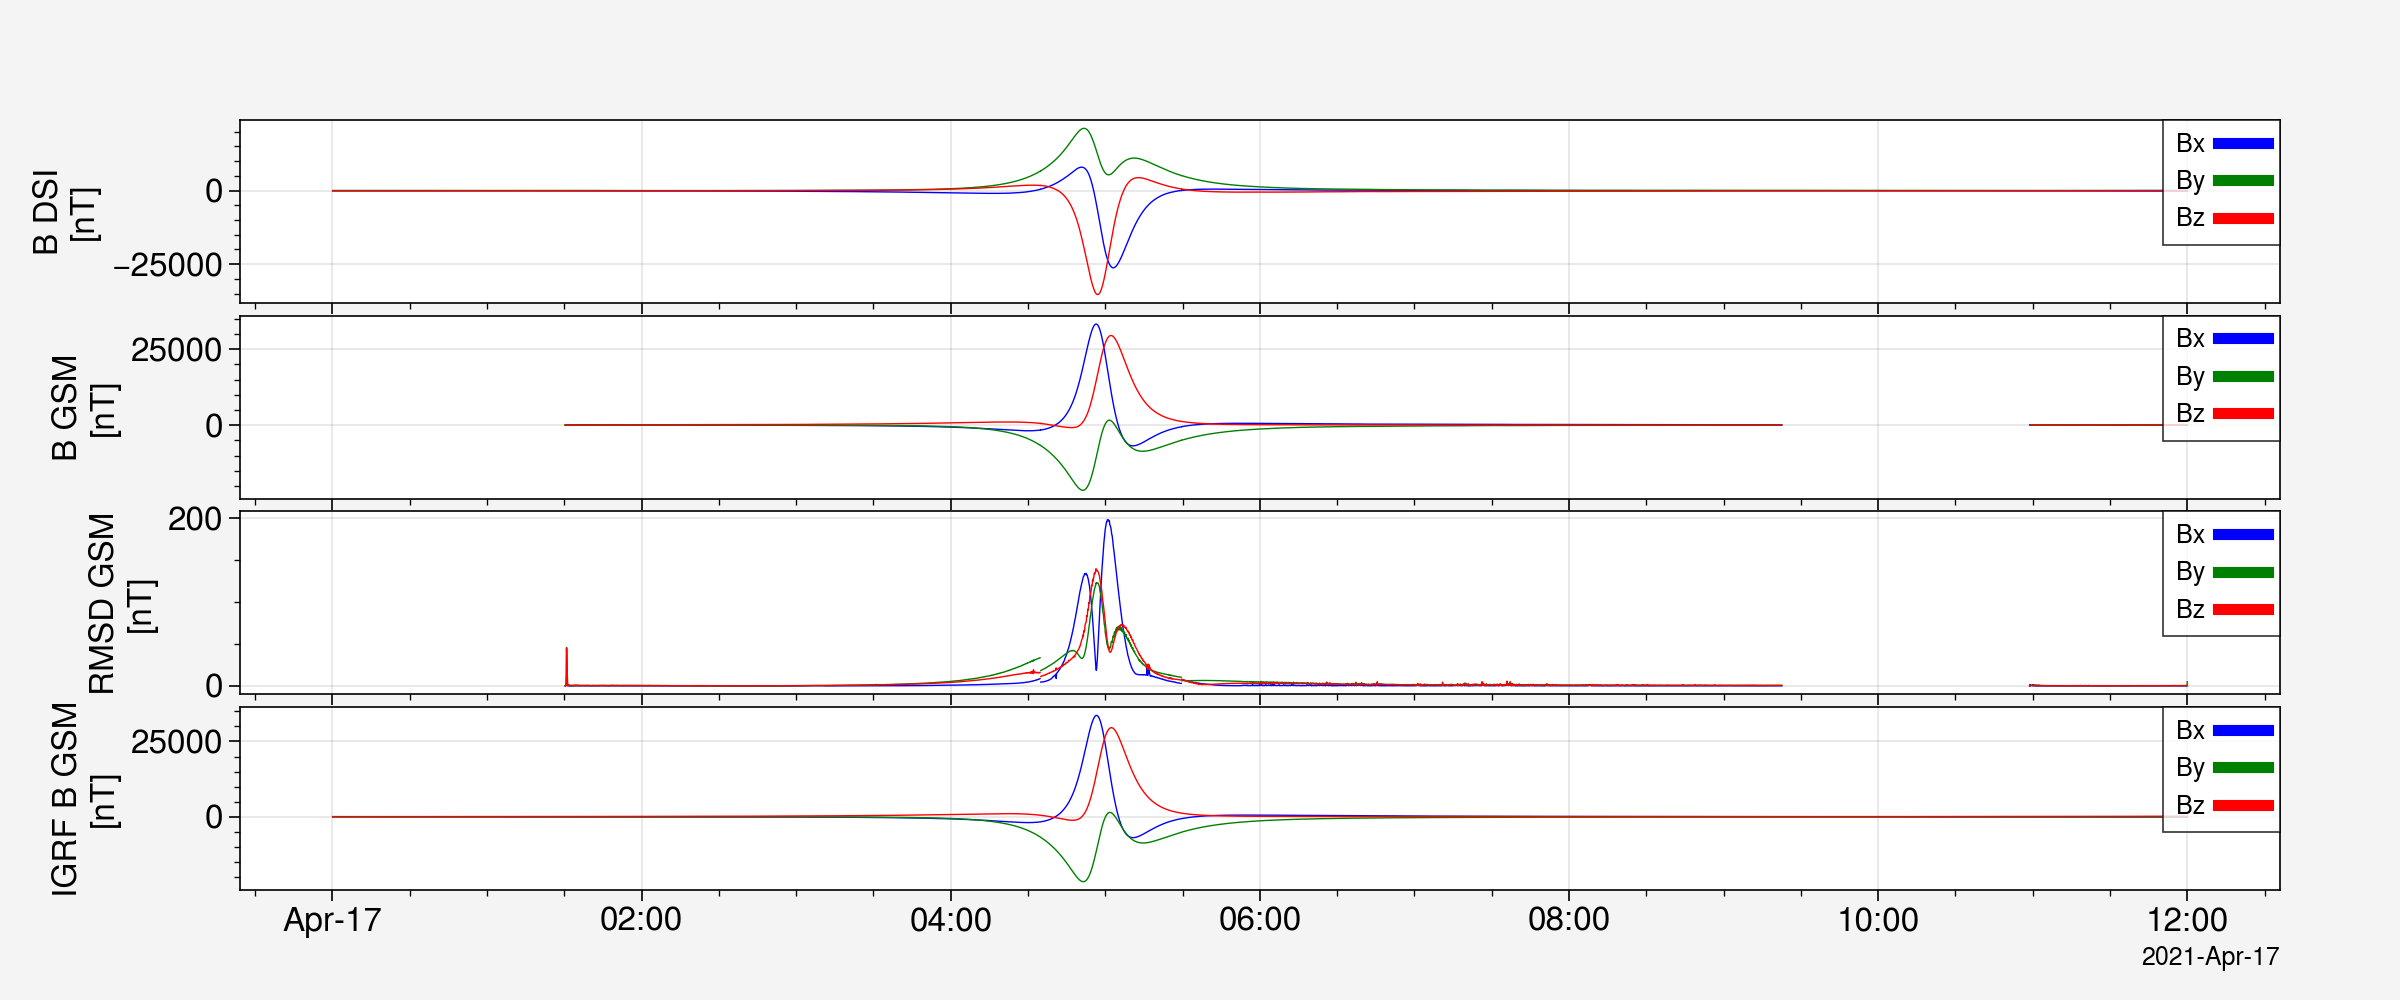

In [9]:
tplot(['erg_mgf_l2_mag_8sec_dsi', 'erg_mgf_l2_mag_8sec_gsm', 'erg_mgf_l2_rmsd_8sec_gsm','erg_mgf_l2_igrf_8sec_gsm'])

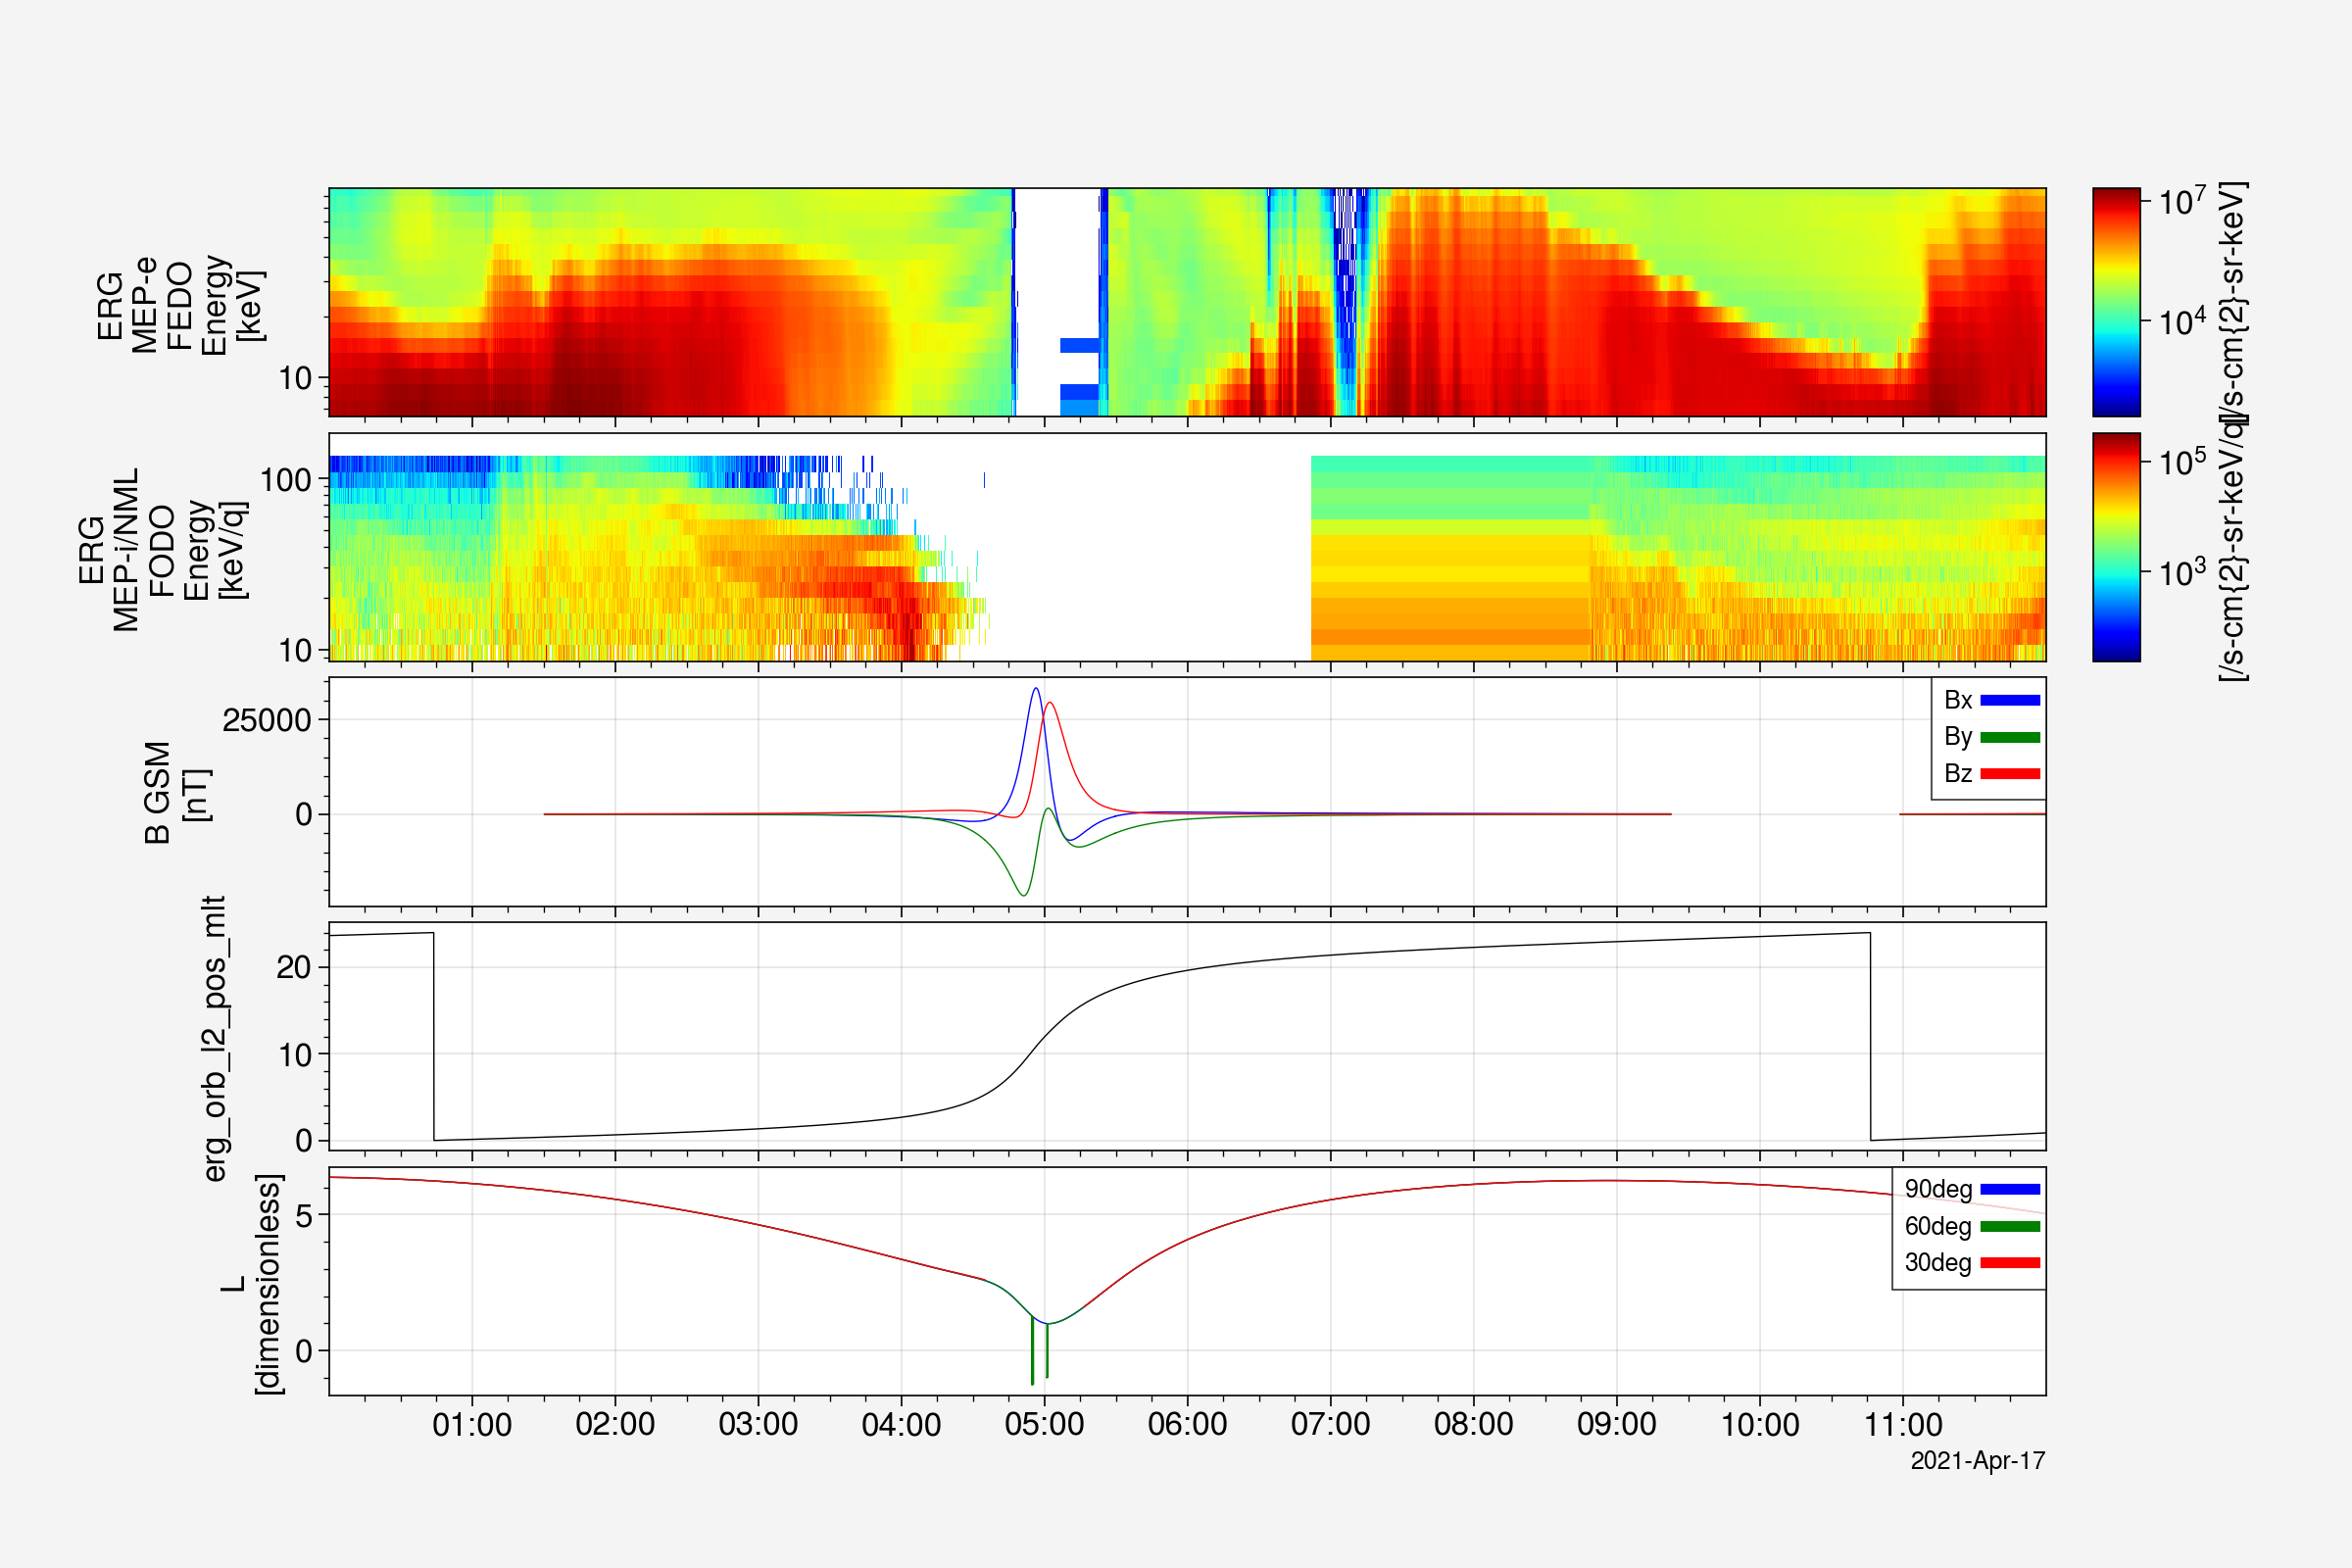

In [10]:
# | code-summary: Overview of ARASE observations
tplot(list(vars.values()))

In [42]:
erg_part_electron = get_data("erg_mepe_l2_omniflux_FEDO", xarray=True)
erg_part_proton = get_data("erg_mepi_l2_omniflux_FODO", xarray=True)
erg_bvec = get_data("erg_mgf_l2_mag_8sec_gsm", xarray=True)
erg_mec_mlt = get_data("erg_orb_l2_pos_mlt", xarray=True)
erg_mec_l = get_data("erg_orb_l2_pos_Lm_90", xarray=True)

# update variable attributes
erg_part_electron.attrs.update({
    "long_name": "ARASE Electron",
    "labels": [f"{erg:0.0f} keV" for erg in erg_part_electron.spec_bins.values],
    # "units": r"$1/s/cm^2/sr/keV$",
})

erg_part_proton.attrs.update({
    "long_name": "ARASE Proton",
    "labels": [f"{erg:0.0f} keV" for erg in erg_part_proton.spec_bins.values],
    # "units": r"$1/s/cm^2/sr/keV$"
})

erg_bvec.attrs.update({
    "long_name": "ARASE B",
    "units": "nT",
    "labels": [r"$B_x$", r"$B_y$", r"$B_z$"],
})

erg_mec_mlt.attrs.update({
    "long_name": "MLT",
})

erg_mec_l.attrs.update({
    "long_name": "L shell",
})

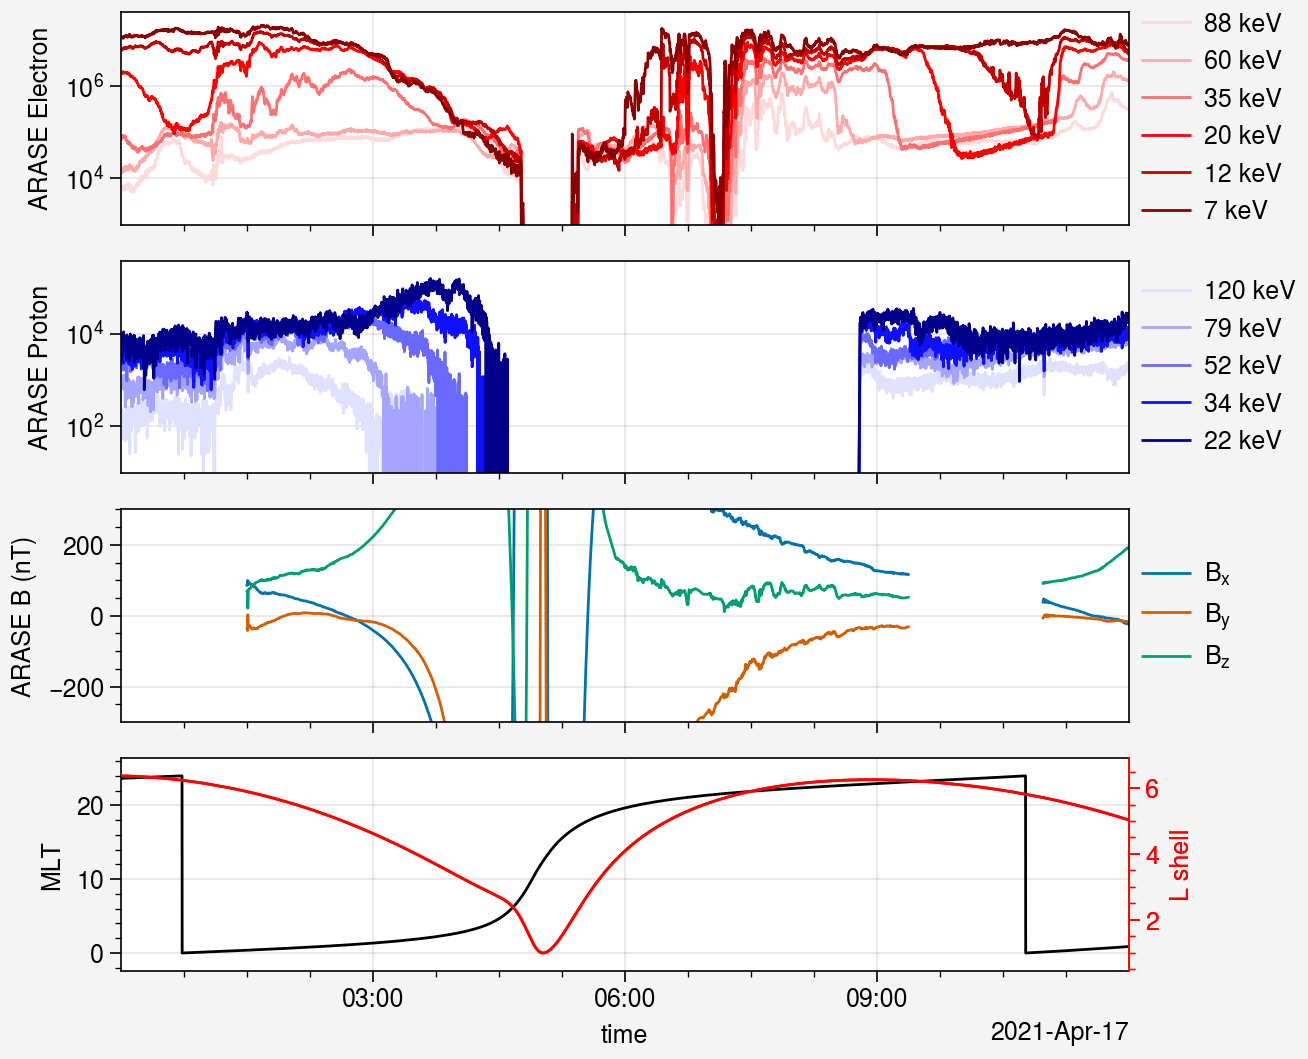

In [61]:
# | code-summary: Plot ARASE electron and proton observations
# | fig-cap: "ARASE electron and proton observations (~10 keV to ~100 keV). Strong electron injection  are visible at the beginning of EMIC-driven electron precipitations and at the end of interval."
def plot_erg_mep(type=None, save=False):
    fname = "arase_mep"

    if type == "poster":
        n = 3
        fname = f"{fname}_poster"
    else:
        n = 4

    # fig, axs = pplt.subplots(
    #     ncols=1, nrows=n, refaspect=n, refwidth=2.5 * n, sharey=False
    # )
    fig, axs = pplt.subplots(
        ncols=1, nrows=n, 
        refwidth=tplot_refwidth, refheight=tplot_refheight,
        sharey=False
    )


    axs[0].plot(
        erg_part_electron[:, ::3],
        cycle="darkred",
        labels=erg_part_electron.attrs["labels"][::3],
    )
    axs[1].plot(
        erg_part_proton[:, 3:-3:2],
        cycle="darkblue",
        labels=erg_part_proton.attrs["labels"][3:-3:2],
    )

    axs[n - 1].plot(erg_mec_mlt, color="black")
    temp_ax = axs[n - 1].alty(color="red", label=erg_mec_l.attrs["long_name"])
    temp_ax.plot(erg_mec_l, color="red")

    axs[0].format(yscale="log", yformatter="log", ymin=1e3)
    axs[0].legend(loc="right", ncols=1, frame=False)
    axs[1].format(yscale="log", yformatter="log")
    axs[1].legend(loc="right", ncols=1, frame=False)
    axs.format(**ax_format_args)
    temp_ax.format(**ax_format_args)

    if not type == "poster":
        axs[2].plot(
            erg_bvec,
            # cycle=["black", "red", "blue"],
            labels=erg_bvec.attrs["labels"],
            ds["erg_mgf"],
            # cycle=["black", "red", "blue"],
            labels=ds["erg_mgf"].attrs["labels"],
        )
        axs[2].format(ylim=(-3e2, 3e2))
        axs[2].legend(loc="right", ncols=1, frame=False)

    if save:
        fig.savefig(f"../figures/{fname}.svg")
        fig.savefig(f"../figures/{fname}.pdf")

    return fig

# fig = plot_erg_mep()
fig = plot_erg_mep(save=True)
# fig = plot_erg_mep(type="poster", save=True)

# fig = plot_erg_mep(type="poster", save=True)
fig = plot_erg_mep()

### Investigate changing fo high energy fluxes over time from ARASE

In [3]:
# | code-summary: Load the data
# | output: false

trange = ["2021-04-16", "2021-04-18"]

pyspedas.erg.xep(trange=trange, time_clip=True, ror=False)
pyspedas.erg.orb(trange=trange, time_clip=True, ror=False)

# xep: 'erg_xep_l2_FEDO_SSD'
# orb: ['erg_orb_l2_pos_llr',
#  'erg_orb_l2_pos_gse',
#  'erg_orb_l2_pos_gsm',
#  'erg_orb_l2_pos_sm',
#  'erg_orb_l2_pos_rmlatmlt',
#  'erg_orb_l2_pos_eq',
#  'erg_orb_l2_pos_iono_north',
#  'erg_orb_l2_pos_iono_south',
#  'erg_orb_l2_pos_blocal',
#  'erg_orb_l2_pos_blocal_mag',
#  'erg_orb_l2_pos_beq',
#  'erg_orb_l2_pos_beq_mag',
#  'erg_orb_l2_pos_Lm',
#  'erg_orb_l2_vel_gse',
#  'erg_orb_l2_vel_gsm',
#  'erg_orb_l2_vel_sm',
#  'erg_orb_l2_spn_num',
#  'erg_orb_l2_man_prep_flag',
#  'erg_orb_l2_man_on_flag',
#  'erg_orb_l2_eclipse_flag']

21-Jun-23 21:06:48: Downloading remote index: https://ergsc.isee.nagoya-u.ac.jp/data/ergsc/satellite/erg/xep/l2/omniflux/2021/04/
21-Jun-23 21:06:48: File is current: /Users/zijin/data/ergsc/satellite/erg/xep/l2/omniflux/2021/04/erg_xep_l2_omniflux_20210416_v01_00.cdf
21-Jun-23 21:06:49: File is current: /Users/zijin/data/ergsc/satellite/erg/xep/l2/omniflux/2021/04/erg_xep_l2_omniflux_20210417_v01_00.cdf
21-Jun-23 21:06:49: /Users/zijin/mambaforge/envs/cool_space_science/lib/python3.10/site-packages/pytplot/importers/cdf_to_tplot.py:310: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if ydata[ydata == var_atts["FILLVAL"]].size != 0:

21-Jun-23 21:06:49: Downloading remote index: https://ergsc.isee.nagoya-u.ac.jp/data/ergsc/satellite/erg/orb/def/2021/
21-Jun-23 21:06:50: File is current: /Users/zijin/data/ergsc/satellite/erg/orb/def/2021/erg_orb_l2_20210416_v03.cdf
21-Jun-23 21:06:51: File is current: /User

['erg_orb_l2_pos_llr',
 'erg_orb_l2_pos_gse',
 'erg_orb_l2_pos_gsm',
 'erg_orb_l2_pos_sm',
 'erg_orb_l2_pos_rmlatmlt',
 'erg_orb_l2_pos_eq',
 'erg_orb_l2_pos_iono_north',
 'erg_orb_l2_pos_iono_south',
 'erg_orb_l2_pos_blocal',
 'erg_orb_l2_pos_blocal_mag',
 'erg_orb_l2_pos_beq',
 'erg_orb_l2_pos_beq_mag',
 'erg_orb_l2_pos_Lm',
 'erg_orb_l2_vel_gse',
 'erg_orb_l2_vel_gsm',
 'erg_orb_l2_vel_sm',
 'erg_orb_l2_spn_num',
 'erg_orb_l2_man_prep_flag',
 'erg_orb_l2_man_on_flag',
 'erg_orb_l2_eclipse_flag']

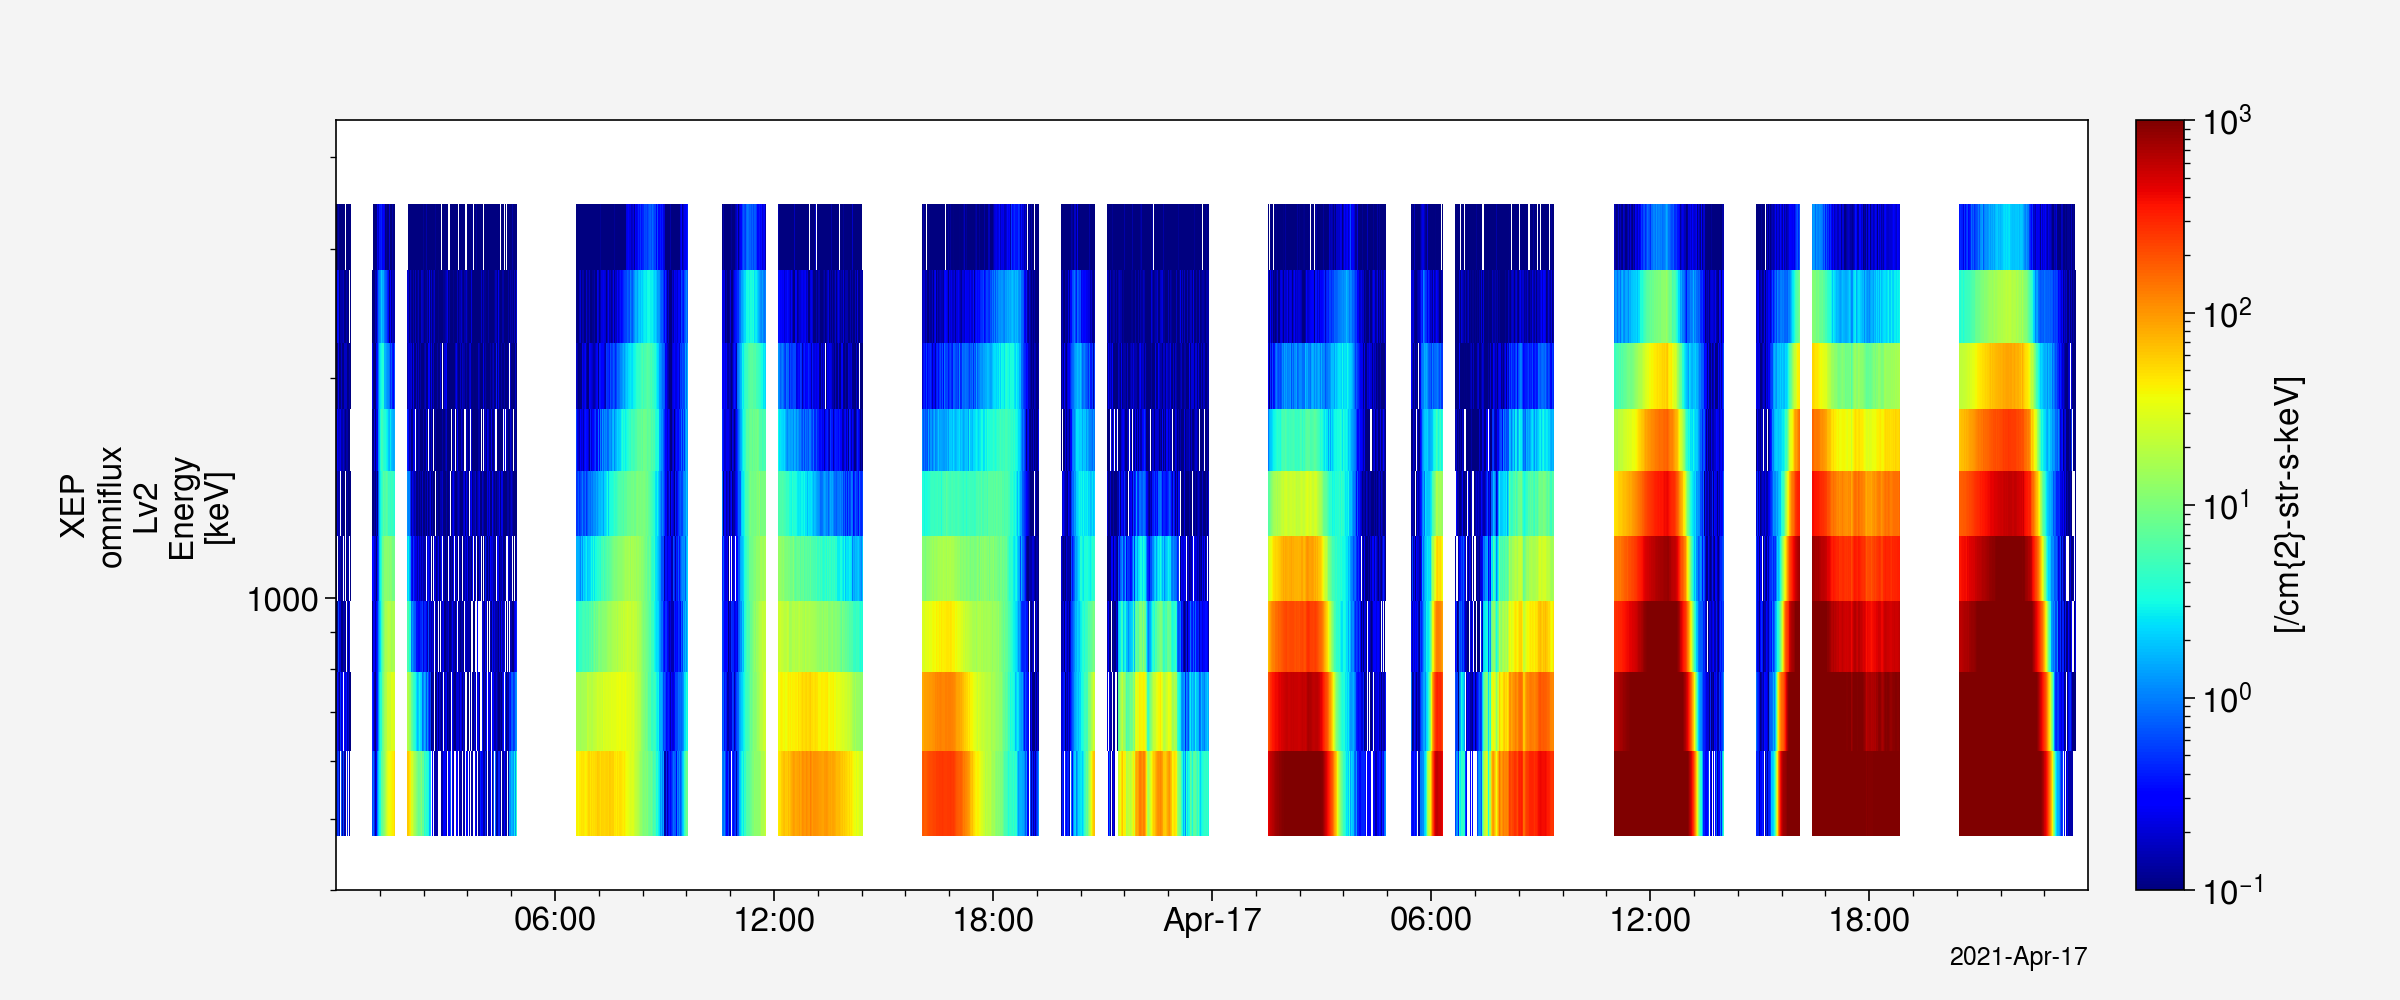

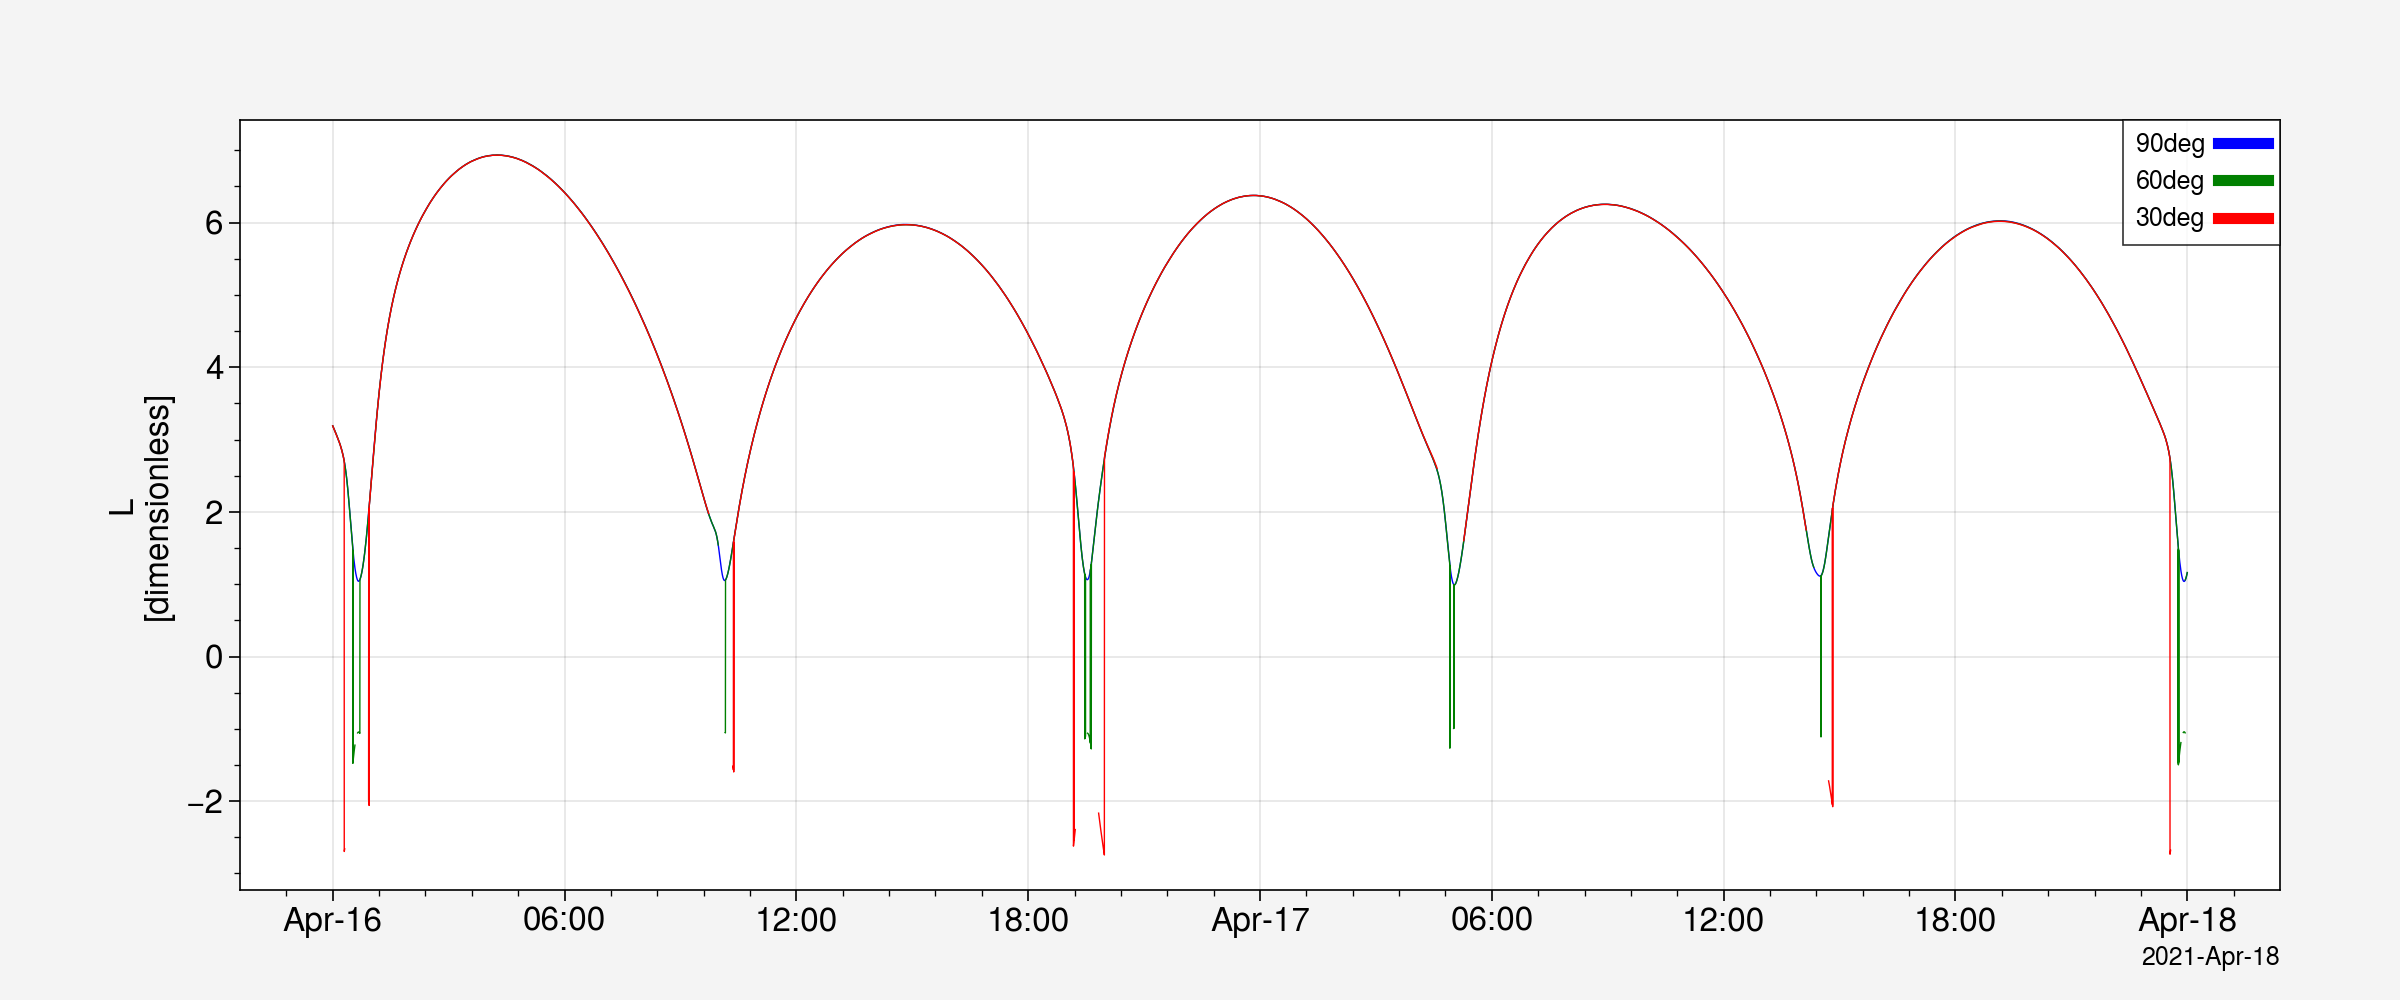

In [4]:
# | code-summary: Plot the overview of the high energy fluxes for ARASE
tplot("erg_xep_l2_FEDO_SSD")
tplot("erg_orb_l2_pos_Lm")

In [ ]:
# | code-summary: Get data from tplot variables
split_vec(
    "erg_orb_l2_pos_rmlatmlt", new_name="erg_orb_l2_pos_", suffix=["r", "mlat", "mlt"]
)

erg_orb_Lm = get_data("erg_orb_l2_pos_Lm", xarray=True)
erg_orb_mlat = get_data("erg_orb_l2_pos_mlat", xarray=True)
erg_orb_mlt = get_data("erg_orb_l2_pos_mlt", xarray=True)
erg_xep = get_data("erg_xep_l2_FEDO_SSD", xarray=True)

In [ ]:
# | code-summary: Filter and group the data


def time_group(time):
    """Group data points by time"""

    # Set a threshold time interval for grouping data
    time_threshold = pd.Timedelta(minutes=30)

    # Compute the time intervals between each data point
    time_delta = time.diff()

    # Create a boolean mask for identifying the start of each group
    group_start_mask = (time_delta > time_threshold) | time_delta.isnull()

    # Assign a group ID to each data point based on the start of each group
    return group_start_mask.cumsum()


erg_orb_pipe = pdp.PdPipeline(
    [
        # only keep data where Lm > 5 and 10 > mlat > -10
        pdp.keep_rows_where["erg_orb_l2_pos_Lm"] > 4.5,
        pdp.keep_rows_where["erg_orb_l2_pos_Lm"] < 5.5,
        pdp.keep_rows_where["erg_orb_l2_pos_mlat"] > -10,
        pdp.keep_rows_where["erg_orb_l2_pos_mlat"] < 10,
        # group data by time
        pdp.ColByFrameFunc("group_id", lambda df: time_group(df.index.to_series())),
    ]
)

erg_orb_df = xr.merge([erg_orb_Lm[:, 0], erg_orb_mlat, erg_orb_mlt]).to_dataframe()
erg_orb_df_filtered = erg_orb_pipe.apply(erg_orb_df)

In [ ]:
# | code-summary: Plot the overview of the ERG orbit during the period of interest
erg_orb_df.hvplot.scatter(
    x="erg_orb_l2_pos_mlt", y="erg_orb_l2_pos_mlat"
) * erg_orb_df_filtered.hvplot.scatter(x="erg_orb_l2_pos_mlt", y="erg_orb_l2_pos_mlat")
erg_orb_df.hvplot(
    x="time", y=["erg_orb_l2_pos_Lm", "erg_orb_l2_pos_mlat", "erg_orb_l2_pos_mlt"]
) * erg_orb_df_filtered.hvplot.scatter(
    x="time", y=["erg_orb_l2_pos_Lm", "erg_orb_l2_pos_mlat", "erg_orb_l2_pos_mlt"]
)

In [ ]:
# | code-summary: Group erg_xep data by orbit groups
erg_orb_tgroup = (
    erg_orb_df_filtered.reset_index()
    .groupby("group_id")
    .agg({"time": ["min", "max"]})
    .to_numpy()
)

erg_xep_df = erg_xep.to_dataframe()

for tr_min, tr_max in erg_orb_tgroup:
    erg_xep_df.loc[tr_min:tr_max, "trange"] = "{}, {}".format(
        tr_min.astype("datetime64[h]"), tr_max.astype("datetime64[h]")
    )

In [ ]:
# | code-summary: A different method to group the data, but it doesn't visualize well (Obsolete)
# | echo: false

# erg_orb_tgroup = (
#     erg_orb_df_filtered.reset_index()
#     .groupby("group_id")
#     .agg({"time": ["min", "max"]})
# )

# bins = pd.IntervalIndex.from_arrays(erg_orb_tgroup['time','min'],erg_orb_tgroup['time','max'])

# erg_xep = erg_xep.assign_coords(trange=("time", pd.cut(erg_xep['time'], bins)))
# erg_xep_df['trange'] = pd.cut(erg_xep_df.reset_index(level='v_dim').index, bins)

In [ ]:
vatt = erg_xep.attrs["CDF"]["VATT"]

chart01 = (
    alt.Chart(erg_xep_df.dropna())
    .mark_line(point=True)
    .encode(
        x=alt.X("spec_bins", title="Energy [keV]"),
        y=alt.Y(
            "mean(erg_xep_l2_FEDO_SSD)",
            scale=alt.Scale(type="log"),
            title=f"{vatt['LABLAXIS']} [{vatt['UNITS']}]",
        ),
        color="trange",
    )
    .properties(title=f"{vatt['CATDESC']}")
)

chart02 = (
    alt.Chart(erg_xep_df.dropna())
    .mark_line(point=True)
    .encode(
        x=alt.X("spec_bins", title="Energy [keV]"),
        y=alt.Y(
            "mean(erg_xep_l2_FEDO_SSD)", title=f"{vatt['LABLAXIS']} [{vatt['UNITS']}]"
        ),
        color="trange",
    )
    .properties(title=f"{vatt['CATDESC']}")
)

display(chart01, chart02)